In [1]:
from spacerocks import SpaceRock, Units

from astroquery.jplhorizons import Horizons

from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
units = Units()
units.timescale = 'tdb' # JPL gives elements in TDB. This actually matters for precise ephemerides.
units.current()

Quantity             Unit           
---------------------------------------
distance             AU             
angle                deg            
timescale            tdb            
timeformat           None           
speed                AU / d         
size                 km             
density              g / cm3        
mass                 kg             
ra                   deg            
dec                  deg            
rotation_curves      False          


In [3]:
rock = SpaceRock.from_horizons(name='Valjean')

In [5]:
startdate = Time('2000-01-01', scale='utc', format='iso')
testdates = Time(np.arange(startdate.jd, startdate.jd + 50 * 365.25, 30), scale='utc', format='jd')

In [6]:
units.timescale = 'utc'

In [7]:
%%time
prop, planets, sim = rock.propagate(epochs=testdates.jd, model=3, units=units, gr=False)

/home/kevin/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 280 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/kevin/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 280 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/kevin/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 7560 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


CPU times: user 12.2 s, sys: 188 ms, total: 12.4 s
Wall time: 12.4 s


In [7]:
%%time
gr_prop, planets, sim = rock.propagate(epochs=testdates.jd, model=3, units=units, gr=True)

CPU times: user 1min 55s, sys: 0 ns, total: 1min 55s
Wall time: 1min 55s


In [8]:
#gr_obs = gr_prop.observe(obscode='W84')
obs = prop.observe(obscode='W84')

In [9]:
rock_id = 'Valjean'
ephem_Horizons = Horizons(id=rock_id, location='W84',
                          epochs={'start':testdates[0].iso, 
                                  'stop':testdates[-1].iso, 
                                  'step':'30d'}).ephemerides()

/home/kevin/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [10]:
pos_Horizons = SkyCoord(ephem_Horizons['RA'], ephem_Horizons['DEC'], frame='icrs', unit=(u.deg, u.deg))
pos_pred = SkyCoord(obs.ra.deg, obs.dec.deg, frame='icrs', unit=(u.deg, u.deg))
sep = pos_pred.separation(pos_Horizons)
#gr_pos_pred = SkyCoord(gr_obs.ra.deg, gr_obs.dec.deg, frame='icrs', unit=(u.deg, u.deg))
#gr_sep = gr_pos_pred.separation(pos_Horizons)

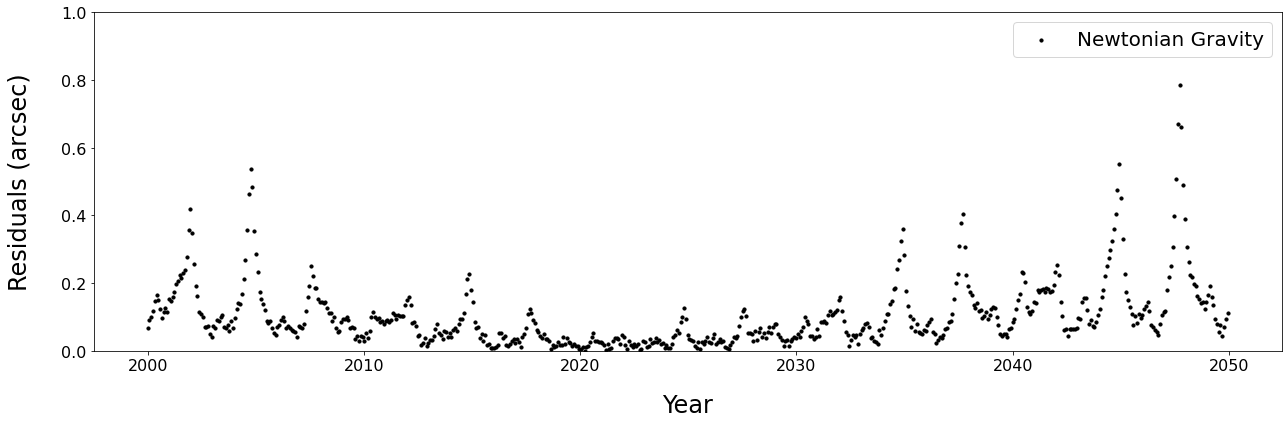

In [11]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.scatter(prop.epoch.decimalyear, sep.arcsec, color='black', s=10, label='Newtonian Gravity')
#ax.scatter(gr_prop.epoch.decimalyear, gr_sep.arcsec, color='red', s=10, label='General Relativity')

ax.tick_params(labelsize=16)
ax.set_xlabel('Year', fontsize=24, labelpad=20)
ax.set_ylabel('Residuals (arcsec)', fontsize=24, labelpad=30)
ax.set_ylim(bottom=0, top=1)
ax.legend(fontsize=20)
fig.tight_layout()
#fig.savefig('/home/kevin/Desktop/Valjean.pdf')